# Pairs Selection using CCM/KNN for Statistical Arbitrage

This notebook documents the steps taken to identify cointegrated pairs using **Convergent Cross Mapping (CCM)** and **K-Nearest Neighbors (KNN)** based similarity, with the goal of implementing a pairs trading strategy.

## Step 1: Load and Preprocess Price Data

In this step, we load historical price data for tech stocks from the SP500 from September 2024 to April 2025 to prepare it for cointegration and nonlinear similarity analysis.

We typically use daily closing prices, as they are sufficient to capture medium-term relationships between assets in a pairs trading context.

The output of this step is a clean time series dataset, where each column represents a stock and each row represents a trading day.

In [2]:
import pandas as pd
import numpy as np

# Data loaded using data.py and cleaned using clean.py

df = pd.read_csv("data/clean/train_prices_clean.csv", index_col=0, parse_dates=True)
df.head()

,AAPL,ACN,ADBE,ADI,ADSK,AMAT,AMD,ANET,ANSS,APH,...,ORCL,PANW,PLTR,QCOM,ROP,SNPS,TEL,TXN,VRSN,WDAY
Date,,,,,,,,,,,,,,,,,,,,,
2024-09-16,215.562271,349.459076,521.500000,221.375412,267.730011,186.709839,152.080002,89.790001,318.049988,62.804119,...,168.924347,173.054993,36.310001,164.854080,554.101868,498.570007,144.643982,194.068832,182.460007,249.210007
2024-09-17,216.030609,332.603851,515.030029,223.427750,266.890015,187.715149,150.820007,90.237503,317.250000,63.684906,...,166.087952,168.964996,36.450001,166.922058,549.392761,502.250000,146.527878,196.924057,182.860001,248.119995
2024-09-18,219.916962,331.755188,508.130005,220.740860,264.209991,185.276520,148.289993,90.427498,313.390015,62.998192,...,163.172226,164.875000,36.380001,166.526276,547.501099,495.950012,144.683640,196.259171,179.270004,248.470001
2024-09-19,228.068314,330.827545,526.440002,231.458649,269.760010,195.797501,156.740005,94.830002,322.290009,64.978706,...,166.206955,166.800003,36.830002,172.087036,558.382874,514.119995,148.114319,202.996384,182.419998,247.429993
2024-09-20,227.400650,331.794647,522.299988,224.845551,267.290009,191.268616,155.949997,96.114998,320.250000,65.595757,...,166.613586,170.059998,37.200001,167.139755,555.575317,506.649994,146.855087,198.791718,181.220001,248.289993


## Step 2: Cointegration scan using Engle-granger test

The goal here is to identify pairs of assets that are **cointegrated**. This means their prices move together over time in a stable long-term relationship, despite being non-stationary individually.

We use the **Engle-Granger test**, which works as follows:
1. Run a linear regression of one asset on another to estimate the hedge ratio (β).
2. Test the residuals of that regression for stationarity using a **unit root test** (Augmented Dickey-Fuller).

If the residuals are stationary (i.e., reject the null hypothesis of a unit root), the two assets are considered **cointegrated**.

This gives us a first list of candidate pairs that might be suitable for pairs trading based on mean-reverting spread behavior.

In [3]:
from cointegration import scan_pairs
import itertools
import itertools as it
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from cointegration import scan_pairs, eagle_granger_test

pairs = scan_pairs(df, p=0.05)
if not pairs:
    print("No cointegrated pairs found in training data at p < 0.05")
else:
    out_df = pd.DataFrame(pairs, columns=["stock1","stock2","pvalue"])
    print(f"Found {len(pairs)} cointegrated pairs in training data")
    print("Training Pairs:")
    print(out_df)

Found 193 cointegrated pairs in training data
Training Pairs:
    stock1 stock2    pvalue
0     AAPL   INTC  0.003325
1     AAPL     MU  0.046456
2     AAPL    TEL  0.046849
3     AAPL   WDAY  0.042247
4      ACN   ANET  0.046493
..     ...    ...       ...
188   PANW    TEL  0.002605
189   PANW   WDAY  0.016349
190   PLTR    TEL  0.024652
191    ROP    TEL  0.018403
192   SNPS    TEL  0.033342

[193 rows x 3 columns]


## Step 3: Compute the CCM filter to filter the pairs having nonlinear relationships

While cointegration tests capture linear long-term relationships, they can miss nonlinear or lagged dependencies that exist between asset prices.

To capture such complex interactions, we apply **Convergent Cross Mapping (CCM)** — a method from nonlinear dynamical systems theory.

**CCM works by:**
- Creating delay embeddings of time series to reconstruct their state-space behavior.
- Measuring how well the past of one time series can predict the present of another using **K-Nearest Neighbors (KNN)**.
- Evaluating whether prediction skill converges as more data is used — a sign of dynamic coupling.

By applying CCM, we filter the cointegrated pairs and retain only those with strong nonlinear dependencies, giving us higher-quality candidates for pairs trading.

This step helps us go beyond linear statistics and tap into hidden structure that may provide stronger trading signals.

The heatmap of CCM scores provides a visual representation of the cross-mapping skill between asset pairs. By comparing these scores with the cointegration p-values, we can identify the pairs that exhibit both strong nonlinear coupling and statistical cointegration, allowing us to select the most promising candidates for our trading strategy.

In-sample CCM-filtered pairs:
   stock1 stock2      r_xy      r_yx
0    ADBE    HPQ  0.836558  0.836557
1    ADSK   ANSS  0.822759  0.822758
2    ADSK    APH  0.832018  0.832016
3    ADSK   CDNS  0.822889  0.822889
4    ADSK    CRM  0.868959  0.868959
5    ADSK    MSI  0.815529  0.815529
6     AMD   MCHP  0.912829  0.912829
7    ANSS    APH  0.837926  0.837926
8    ANSS    CRM  0.867640  0.867640
9    ANSS   GDDY  0.806158  0.806157
10   ANSS    NOW  0.833649  0.833649
11    APH   CDNS  0.851589  0.851589
12   CDNS    CRM  0.827928  0.827929
13   CDNS    NOW  0.875635  0.875635
14    CRM   WDAY  0.803878  0.803878
15   CRWD   CTSH  0.808502  0.808502
16   CRWD   FTNT  0.928104  0.928103
17   CRWD    GLW  0.839700  0.839699
18   CRWD   PLTR  0.930508  0.930507
19   CSCO   FTNT  0.935126  0.935128
20   CSCO   PLTR  0.905552  0.905552
21   CTSH   FTNT  0.827336  0.827336
22   DELL    HPQ  0.927943  0.927942
23   DELL   NVDA  0.803472  0.803471
24   DELL   ORCL  0.831319  0.831320
25   FIC

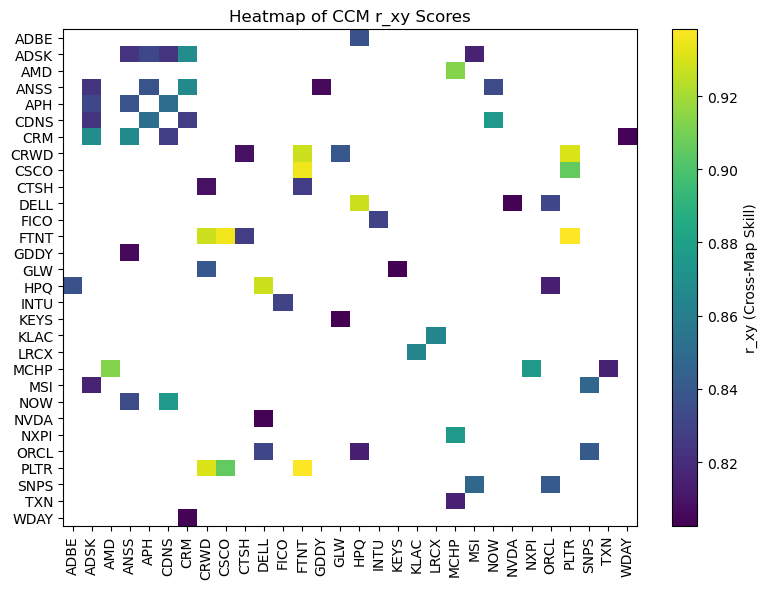

In [4]:
from sklearn.neighbors import NearestNeighbors
from scipy.stats import zscore, pearsonr
from ccm_filter import filter_ccm
import matplotlib.pyplot as plt

pairs = pd.DataFrame(
    pairs,
    columns=["stock1","stock2","pvalue"]
)

# Backtested in train_ccm to find the best embedding dimension E and neighbors k
good = filter_ccm(df, pairs, E=4, tau=1, k=5, r_tresh=0.8)
out = pd.DataFrame(good, columns=["stock1","stock2","r_xy","r_yx"])
print("In-sample CCM-filtered pairs:")
print(out)

# Heatmap for visualization

tickers = sorted(set(out['stock1']).union(out['stock2']))
matrix = pd.DataFrame(np.nan, index=tickers, columns=tickers)

for _, row in out.iterrows():
    t1, t2, r_xy, r_yx = row['stock1'], row['stock2'], row['r_xy'], row['r_yx']
    matrix.loc[t1, t2] = r_xy
    matrix.loc[t2, t1] = r_yx  # mirror for symmetry

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(matrix.values, aspect='auto', interpolation='nearest')

cbar = fig.colorbar(im, ax=ax)
cbar.set_label('r_xy (Cross-Map Skill)')

ax.set_xticks(range(len(tickers)))
ax.set_yticks(range(len(tickers)))
ax.set_xticklabels(tickers, rotation=90)
ax.set_yticklabels(tickers)
ax.set_title('Heatmap of CCM r_xy Scores')

plt.tight_layout()
plt.show()

## Step 4: Test the filter on pairs from the Testing set

In-sample CCM-filtered pairs:
   stock1 stock2      r_xy      r_yx
0    ADBE    HPQ  0.932435  0.932435
1    ADSK   ANSS  0.983955  0.983955
2    ADSK    APH  0.950906  0.950906
3    ADSK   CDNS  0.956534  0.956534
4    ADSK    CRM  0.929928  0.929929
5     AMD   MCHP  0.907617  0.907617
6    ANSS    APH  0.964364  0.964364
7    ANSS    CRM  0.936627  0.936628
8    ANSS   GDDY  0.842975  0.842976
9    ANSS    NOW  0.950397  0.950398
10    APH   CDNS  0.980265  0.980265
11   CDNS    CRM  0.929271  0.929272
12   CDNS    NOW  0.978386  0.978386
13    CRM   WDAY  0.971260  0.971259
14   CRWD   CTSH  0.832165  0.832164
15   CRWD   FTNT  0.929874  0.929874
16   CRWD    GLW  0.923256  0.923256
17   CRWD   PLTR  0.953462  0.953461
18   DELL    HPQ  0.967382  0.967381
19   DELL   NVDA  0.807939  0.807941
20   DELL   ORCL  0.891676  0.891677
21   FICO   INTU  0.962349  0.962349
22   FTNT   PLTR  0.831645  0.831643
23    GLW   KEYS  0.959973  0.959972
24    HPQ   ORCL  0.918271  0.918272
25   KLA

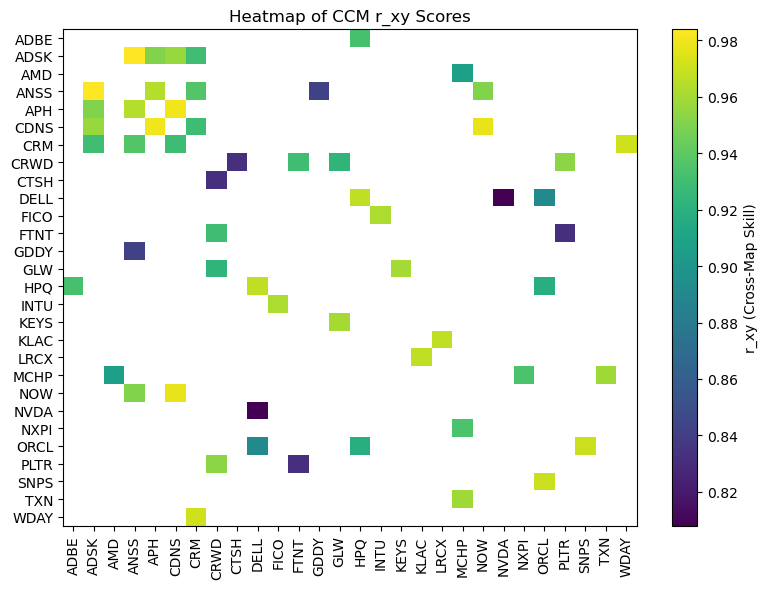

In [5]:
# Load testing data
df_test = pd.read_csv("data/clean/test_prices_clean.csv", index_col=0, parse_dates=True)
df_test.head()

pairs = out

good = filter_ccm(df_test, pairs, E=4, tau=1, k=5, r_tresh=0.8)
out = pd.DataFrame(good, columns=["stock1","stock2","r_xy","r_yx"])
print("In-sample CCM-filtered pairs:")
print(out)

# Heatmap for visualization

tickers = sorted(set(out['stock1']).union(out['stock2']))
matrix = pd.DataFrame(np.nan, index=tickers, columns=tickers)

for _, row in out.iterrows():
    t1, t2, r_xy, r_yx = row['stock1'], row['stock2'], row['r_xy'], row['r_yx']
    matrix.loc[t1, t2] = r_xy
    matrix.loc[t2, t1] = r_yx  # mirror for symmetry

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(matrix.values, aspect='auto', interpolation='nearest')

cbar = fig.colorbar(im, ax=ax)
cbar.set_label('r_xy (Cross-Map Skill)')

ax.set_xticks(range(len(tickers)))
ax.set_yticks(range(len(tickers)))
ax.set_xticklabels(tickers, rotation=90)
ax.set_yticklabels(tickers)
ax.set_title('Heatmap of CCM r_xy Scores')

plt.tight_layout()
plt.show()

## Results of the test

Survival rate: 29/34 = 85.3%


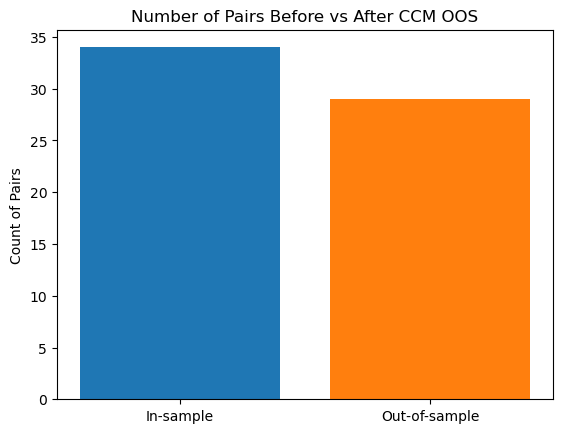

In [6]:
import matplotlib.pyplot as plt

N_train = len(pairs)
N_test  = len(out)

retention_rate = N_test / N_train * 100
print(f"Survival rate: {N_test}/{N_train} = {retention_rate:.1f}%")

plt.bar(["In-sample","Out-of-sample"], [N_train, N_test], color=["C0","C1"])
plt.title("Number of Pairs Before vs After CCM OOS")
plt.ylabel("Count of Pairs")
plt.show()

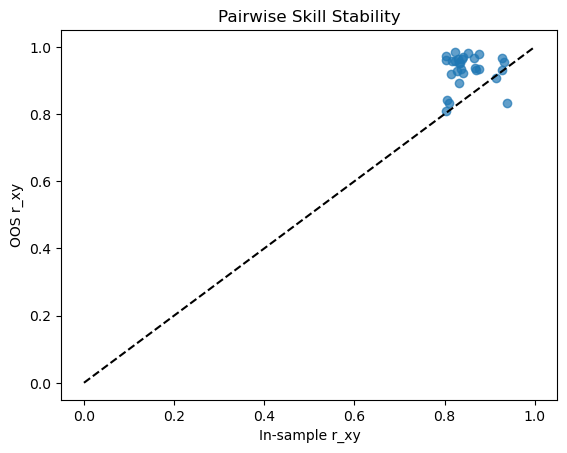

In [53]:
merged = pd.merge(
    pairs.assign(pair=pairs.stock1+"-"+pairs.stock2),
    out.assign(pair=out.stock1 + "-" + out.stock2),
    on="pair", suffixes=("_train","_test")
)

plt.scatter(merged["r_xy_train"], merged["r_xy_test"], alpha=0.7)
plt.plot([0,1],[0,1], "k--")
plt.xlabel("In-sample r_xy")
plt.ylabel("OOS r_xy")
plt.title("Pairwise Skill Stability")
plt.show()

Odd that a lot of pairs have a higher score, is it a fluke?

In [54]:
import os

out.to_csv("data/processed/universal_pairs_t.csv", index=False)
print("In-sample CCM-filtered pairs saved")

In-sample CCM-filtered pairs saved


## ML model and result

Top 3 Pairs:
           sharpe  wl_ratio  num_trades
pair                                   
CRWD-PLTR   4.238       inf           2
FICO-INTU   4.013       3.0           8
ADBE-HPQ    3.408       3.0           4


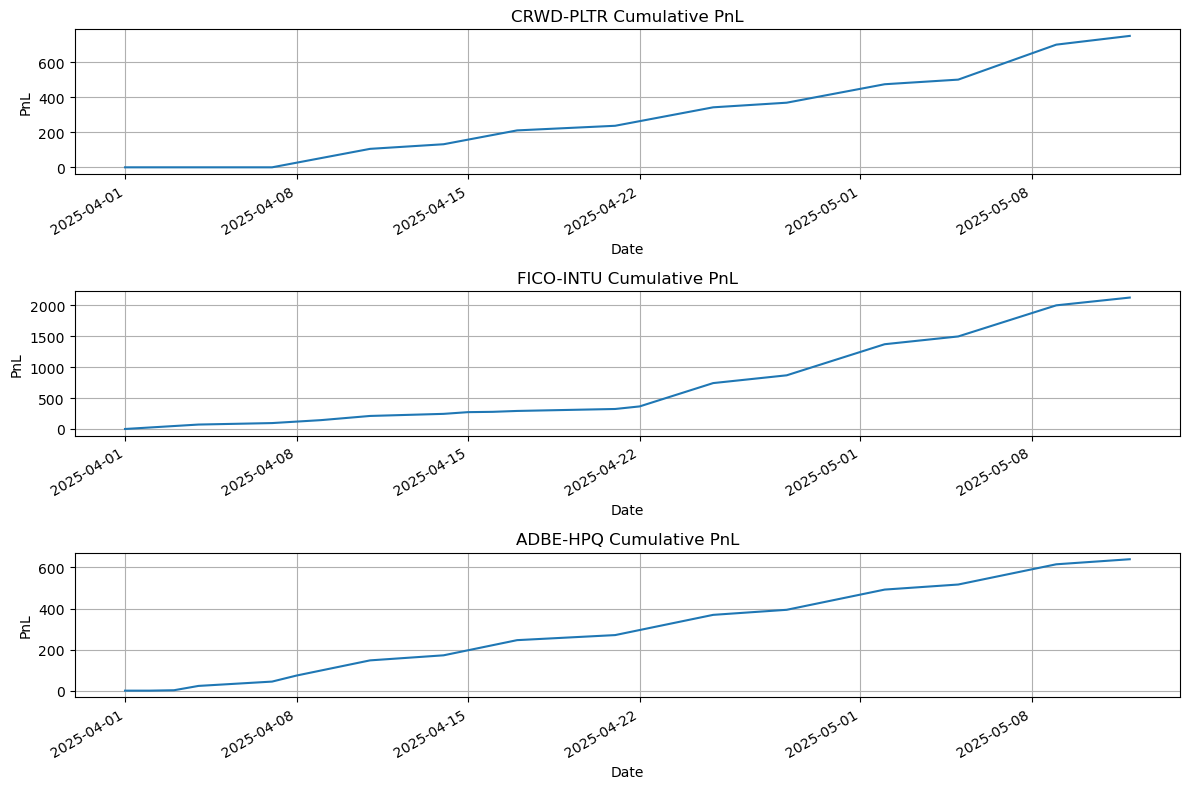

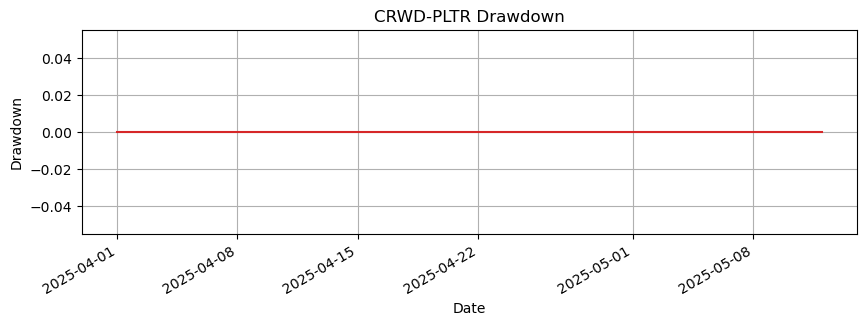

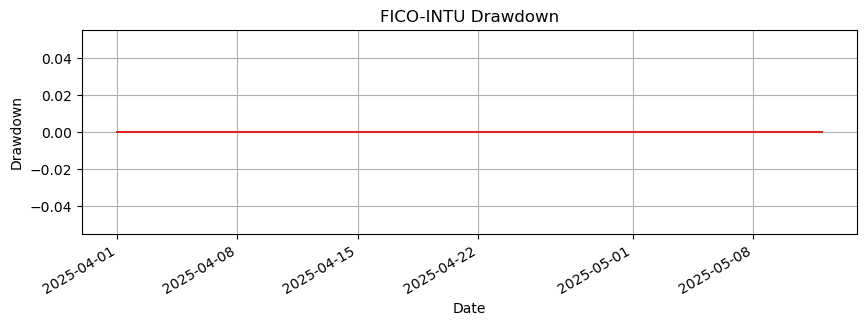

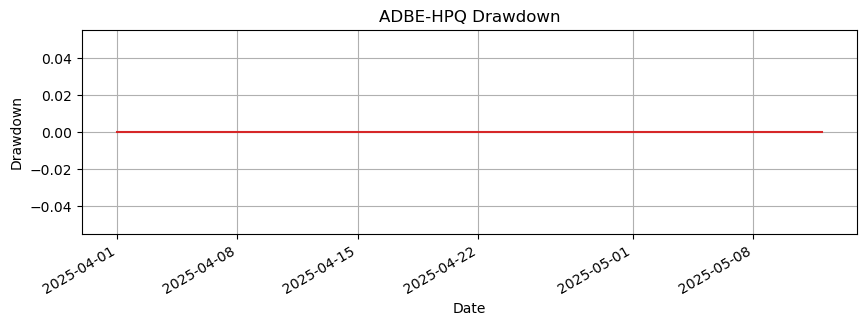

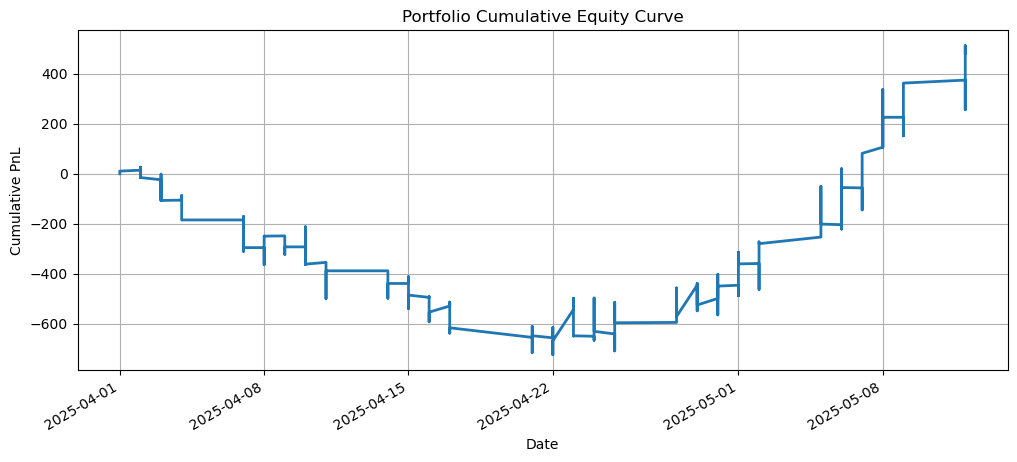

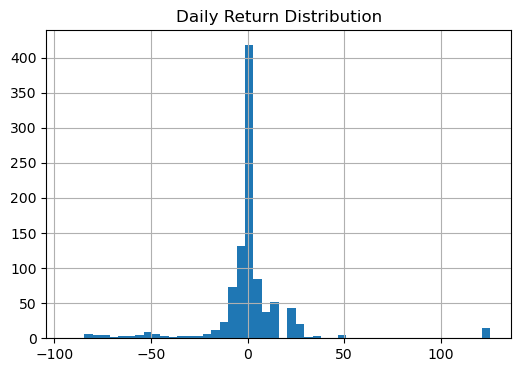

In [16]:
# Load your summary metrics

summary = pd.read_csv("results/backtest_summary.csv", index_col=0)
top3 = summary.sort_values("sharpe", ascending=False).head(3)

print("Top 3 Pairs:")
print(top3)

# Plot each of the top 3 equity curves
plt.figure(figsize=(12, 8))
for i, pair in enumerate(top3.index, 1):
    pnl = (
        pd.read_csv(f"results/pnl-{pair}.csv", index_col=0, parse_dates=True)
        .squeeze()
        .cumsum()
    )
    ax = plt.subplot(3, 1, i)
    pnl.plot(ax=ax, title=f"{pair} Cumulative PnL")
    ax.set_ylabel("PnL")
    ax.grid(True)

plt.tight_layout()
plt.show()

# Equity curve of Portfolio

all_returns = pd.concat(
    pd.read_csv(f"results/pnl-{p}.csv", index_col=0, parse_dates=True).squeeze()
    for p in summary.index
).sort_index()

cum_equity = all_returns.cumsum()

plt.figure(figsize=(12,5))
cum_equity.plot(title="Portfolio Cumulative Equity Curve", linewidth=2)
plt.xlabel("Date")
plt.ylabel("Cumulative PnL")
plt.grid(True)
plt.show()


# Return distribution for top 3 pairs


# 5) Overall strategy curve


# 6) Return distribution
plt.figure(figsize=(6,4))
all_returns.hist(bins=50)
plt.title("Daily Return Distribution")
plt.show()

In [20]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from model import (
    construct_spread,
    compute_zscore,
    create_train_features,
)
from model import generate_signals
from sklearn.metrics import confusion_matrix, roc_curve, auc

# 1) Load summary & pick top 3
summary = pd.read_csv("results/backtest_summary.csv", index_col=0)
top3 = summary.sort_values("sharpe", ascending=False).head(3)
print("Top 3 pairs:\n", top3)

# 2) Load full price history
prices = pd.read_csv("data/clean/test_prices_clean.csv", index_col=0, parse_dates=True)

# 3) Loop over top 3
for pair in top3.index:
    A, B = pair.split("-")
    print(f"\n## Pair: {A}/{B}")

    # -- reconstruct train & test spreads & z-score on full span of interest --
    # here we'll treat the entire backtest period as "test" for diagnostics
    # but you can narrow to your test dates if you saved them
    price_A = prices[A]
    price_B = prices[B]

    # load saved model + alpha, beta
    model, alpha, beta = joblib.load(f"models/{A}_{B}.joblib")

    # reconstruct spread on full history
    spread = price_A - (alpha + beta * price_B)
    z_full = compute_zscore(spread, window=60)

    # 4) Build labeled features (train_features routine gives you y_true)
    df_all = create_train_features(z_full, spread)  
    X_all  = df_all[['lag1','lag2','momentum','volatility']]
    y_true = df_all['target']
    
    # 5) Predict
    y_pred = model.predict(X_all)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_all)[:,1]
    else:
        # fallback: map preds 0/1 to probabilities
        y_prob = y_pred
    
    # 6) Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Pred Revert","Pred No-Revert"],
                yticklabels=["Actual Revert","Actual No-Revert"])
    plt.title(f"{pair} Confusion Matrix")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

    # 7) ROC Curve + AUC
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(4,4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0,1], [0,1], linestyle="--", color="grey")
    plt.title(f"{pair} ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()

Top 3 pairs:
            sharpe  wl_ratio  num_trades
pair                                   
CRWD-PLTR   4.238       inf           2
FICO-INTU   4.013       3.0           8
ADBE-HPQ    3.408       3.0           4

## Pair: CRWD/PLTR


ValueError: Found array with 0 sample(s) (shape=(0, 4)) while a minimum of 1 is required by RandomForestClassifier.